In [1]:
import os 
import pickle 
import numpy as np
import matplotlib.pylab as plt 
from getdist import plots, MCSamples

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
contours = [0.68,0.95]
linewidth = 2 

In [2]:
def triangle_plot(mcmc_samples, labels, subplot_size = 2, font_size = 18, fname = None):
    ndim = len(labels)
    colour = 'green'
    names = ["x%s"%i for i in range(ndim)]
    samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, settings = settings)
    
    G = plots.getSubplotPlotter(subplot_size=subplot_size)
    samples.updateSettings({'contours': contours})
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.6
    G.settings.num_plot_contours = 2
    G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':colour}, contour_colors=[colour])
    
    for i in range(0,ndim):
        for j in range(0, i+1):
            if i != j:
                ax = G.subplots[i,j]

                a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
                density = G.sample_analyser.get_density_grid(samples, a, b)
                density.contours = density.getContourLevels(contours)
                contour_levels = density.contours

                ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = colour, linewidths = linewidth) 
                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
            else:
                ax = G.subplots[i,j]   

                dense = samples.get1DDensity('x'+str(i))
                dense.normalize(by='max')
                ax.plot(dense.x, dense.P, lw = linewidth+2, c = colour)

                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
    if fname is not None:
        os.makedirs('plots', exist_ok=True)
        plt.savefig(f'plots/triangle_plot_{fname}.pdf', bbox_inches = 'tight')
    plt.close()

In [3]:
from typing import Any

In [4]:
def pickle_load(folder: str, fname: str) -> Any:
    """Reads a list from a folder.
    Args:
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    Returns:
        Any: sampler, list or dataframe
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = pickle.load(dummy)
    return file

In [5]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$',
          r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$', 
          r'$\delta z_{1}^{(s)}$', r'$\delta z_{2}^{(s)}$', r'$\delta z_{3}^{(s)}$', r'$\delta z_{4}^{(s)}$',
          r'$A_{IA}$', r'$\eta$', r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$',
         r'$\delta z_{1}^{(g)}$', r'$\delta z_{2}^{(g)}$', r'$\delta z_{3}^{(g)}$', r'$\delta z_{4}^{(g)}$', r'$\delta z_{5}^{(g)}$']

In [6]:
labels_cosmo = labels[0:5]
labels_multiplicative = labels[5:9]
labels_shift_shear = labels[9:13]
labels_intrinsic = labels[13:15]
labels_bias = labels[15:20]
labels_shift_galaxy = labels[20:]

In [7]:
def emcee_lnpost(parameters):
    pass

In [24]:
sampler = pickle_load('samples', 'samples_emu_50_5000_2')

In [25]:
flat_samples = sampler.get_chain(discard=100, thin=2, flat=True) # sampler.flatchain # 
# flat_lnprob = sampler.get_log_prob(discard=100, thin=2, flat=True)

In [26]:
flat_samples.shape

(122500, 25)

In [27]:
samples = flat_samples[:,0:5]

In [28]:
triangle_plot(samples, labels_cosmo, subplot_size = 2, font_size = 18, fname = 'cosmo_emu_2')

Removed no burn in


# $\Omega_{m}$ vs $S_{8}$

In [29]:
omega_matter = samples[:,1] + samples[:,2]
s8_parameter = samples[:,0] * np.sqrt(omega_matter/0.3)
samples_om_s8 = np.c_[np.atleast_2d(omega_matter).T, np.atleast_2d(s8_parameter).T]

In [30]:
names    = ["x%s"%i for i in range(2)]
labels   =  [r'$\Omega_{m}$', r'$S_{8}=\sigma_{8}\sqrt{\Omega_{m}/0.3}$']

## Planck

In [31]:
folder = '/home/harry/Desktop/Planck/base/plikHM_TTTEEE_lowl_lowE/'

c1 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_1.txt')
c2 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_2.txt')
c3 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_3.txt')
c4 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_4.txt')

s1 = np.array([c1[:,31], c1[:,36]]).T
s2 = np.array([c2[:,31], c2[:,36]]).T
s3 = np.array([c3[:,31], c3[:,36]]).T
s4 = np.array([c4[:,31], c4[:,36]]).T

samples_planck = np.concatenate([s1, s2, s3, s4])

In [32]:
samples_1 = MCSamples(samples=samples_om_s8,names = names, labels = labels, settings = settings)
samples_2 = MCSamples(samples=samples_planck,names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in


In [33]:
legend_labels_ = [r'DES Y1 ($3\times2$) JAX Cosmo', 'Planck 2018']

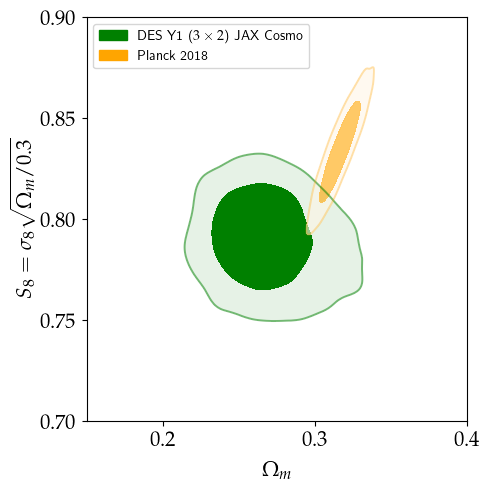

In [34]:
G = plots.getSinglePlotter(width_inch=5, ratio=1.0)
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1.0
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.6
G.settings.legend_fontsize = 10
G.plot_2d([samples_1, samples_2], 'x0', 'x1', filled=[True, True], colors =['green', 'orange'], lims = [0.15, 0.4, 0.7, 0.9])
G.add_legend(legend_labels_, legend_loc='upper left');
# plt.savefig(f'plots/S8_OM_emu.pdf', bbox_inches = 'tight')
plt.show()

# Two Sets of Samples

In [84]:
sampler_1 = pickle_load('samples', 'samples_emu_50_5000_1')
sampler_2 = pickle_load('samples', 'samples_jaxcosmo_50_5000_2')

In [85]:
flat_samples_1 = sampler_1.get_chain(discard=100, thin=2, flat=True) 
flat_samples_2 = sampler_2.get_chain(discard=100, thin=2, flat=True) 

In [86]:
ndim = len(labels_cosmo)
names = ["x%s"%i for i in range(ndim)]

In [87]:
samples_1 = MCSamples(samples=flat_samples_1[:,0:5],names = names, labels = labels_cosmo, settings = settings, label = 'Emulator')
samples_2 = MCSamples(samples=flat_samples_2[:,0:5],names = names, labels = labels_cosmo, settings = settings, label = 'JAX-COSMO')

Removed no burn in
Removed no burn in


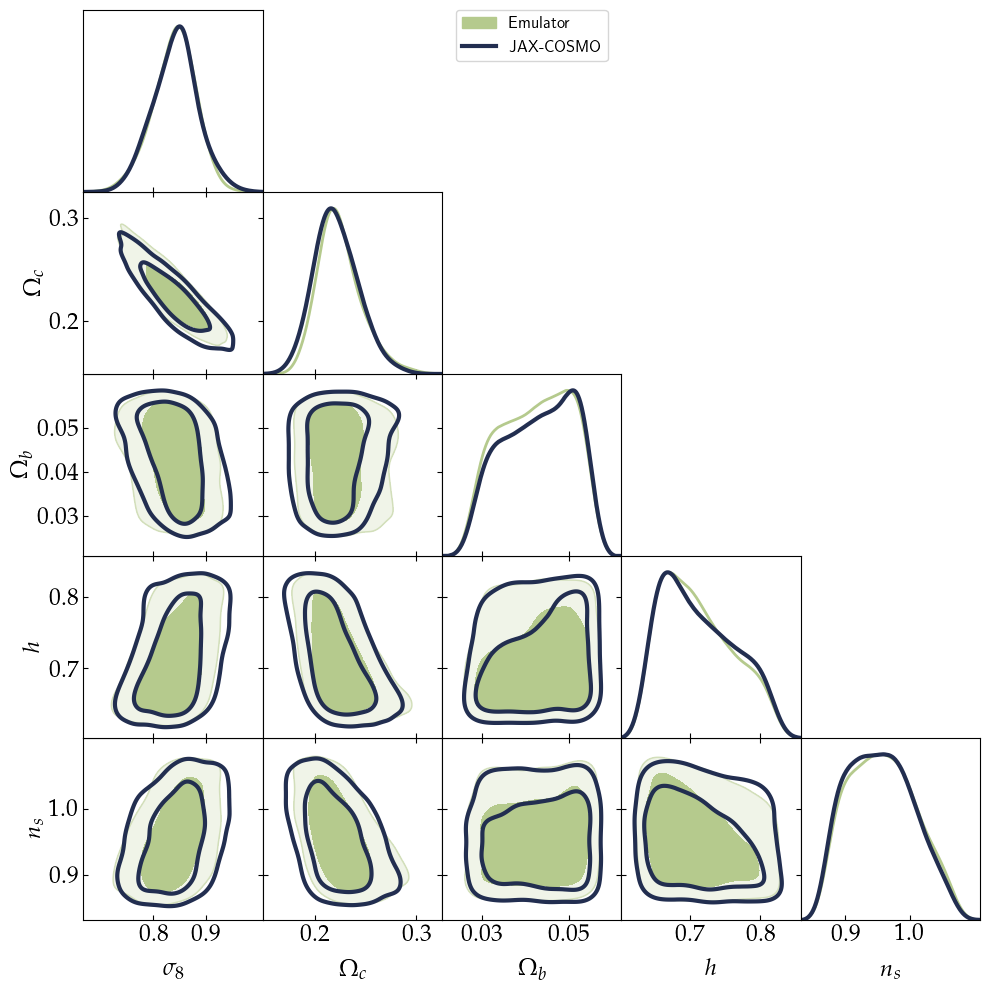

In [88]:
c1 = '#B5CA8D'
c3 = '#222E50'
alpha = 0.7
contours = np.array([0.68,0.95])

G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True,False], contour_colors=[c1, c3], contour_lws=[2,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

# $\Omega_{m}$ vs $S_{8}$

In [89]:
omega_matter_1 = flat_samples_1[:,1] + flat_samples_1[:,2]
s8_parameter_1 = flat_samples_1[:,0] * np.sqrt(omega_matter_1/0.3)
samples_om_s8_1 = np.c_[np.atleast_2d(omega_matter_1).T, np.atleast_2d(s8_parameter_1).T]

omega_matter_2 = flat_samples_2[:,1] + flat_samples_2[:,2]
s8_parameter_2 = flat_samples_2[:,0] * np.sqrt(omega_matter_2/0.3)
samples_om_s8_2 = np.c_[np.atleast_2d(omega_matter_2).T, np.atleast_2d(s8_parameter_2).T]

In [90]:
names    = ["x%s"%i for i in range(2)]
labels   =  [r'$\Omega_{m}$', r'$S_{8}=\sigma_{8}\sqrt{\Omega_{m}/0.3}$']

In [91]:
samples_getdist_1 = MCSamples(samples=samples_om_s8_1,names = names, labels = labels, settings = settings)
samples_getdist_2 = MCSamples(samples=samples_om_s8_2,names = names, labels = labels, settings = settings)
samples_getdist_p = MCSamples(samples=samples_planck,names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in
Removed no burn in


In [92]:
legend_labels_ = ['Emulator', 'JAX-COSMO', 'Planck 2018']

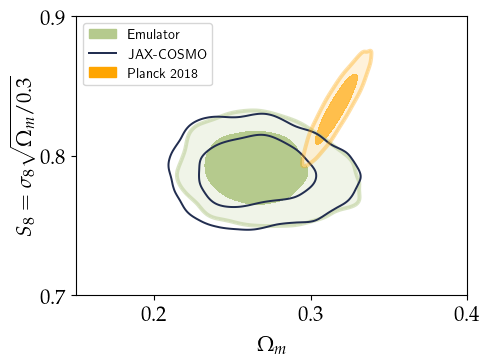

In [93]:
G = plots.getSinglePlotter(width_inch=5, ratio=0.75)
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.legend_fontsize = 10
G.plot_2d([samples_getdist_1, samples_getdist_2, samples_getdist_p], 'x0', 'x1', filled=[True, False, True], colors =[c1, c3, 'orange'], lims = [0.15, 0.4, 0.7, 0.9])
G.add_legend(legend_labels_, legend_loc='upper left');
# plt.savefig(f'plots/S8_OM_comparison.pdf', bbox_inches = 'tight')
plt.show()

# Diagnostics

In [79]:
from utils.diagnostics import gelmanRubin

In [80]:
flat_samples_1.shape

(122500, 25)

In [81]:
flat_samples_2.shape

(122500, 25)

In [82]:
gelmanRubin(flat_samples_1, flat_samples_2)

array([1.00221239, 1.01813957, 1.00380996, 1.00119222, 1.00354098,
       1.01252743, 1.01391151, 1.03914292, 1.00005501, 1.01166057,
       1.00243143, 1.00918068, 1.000113  , 1.02156145, 1.02605952,
       1.06147279, 1.0568563 , 1.10246282, 1.1337471 , 1.04869327,
       1.0049126 , 1.00403262, 1.00182379, 1.00058842, 1.00026012])